<a href="https://colab.research.google.com/github/nickfreij/Pytorch-Projects/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Binary Classification

In [ ]:
#Define Accuracy
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

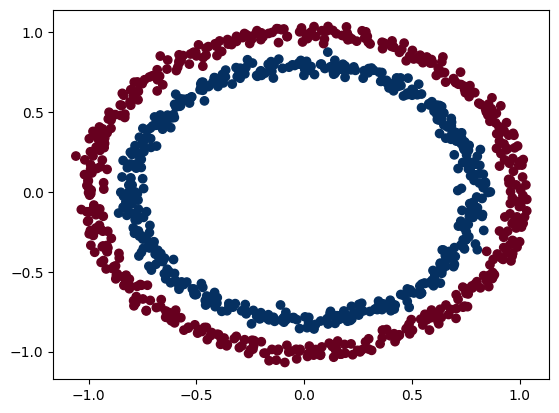

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

In [ ]:
#Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()# <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    # Intersperse the ReLU activation function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_relu = CircleModelV2().to(device)
print(model_relu)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
#Train the model

#setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_relu.parameters(), lr=0.1)

#fit model
torch.manual_seed(42)
epochs=1000

#put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # 1. Forward Pass
  y_logits = model_relu(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # logits -> prediction probabilities -> prediction labels

  #2. Calculate Loss
  loss = loss_fn(y_logits, y_train) #BCEWithLogits Loss calcs loss using logits
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  #3. Optim. zero grad
  optimizer.zero_grad()

  #4. Loss Backward
  loss.backward()

  #5. Optimizer Step
  optimizer.step()

  # Testing
  model_relu.eval()
  with torch.inference_mode():
    #1.Forward Pass
    test_logits = model_relu(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calc. loss acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    #Print results
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69928, Accuracy: 50.00% | Test Loss: 0.69886, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68838, Accuracy: 59.25% | Test Loss: 0.69025, Test Accuracy: 56.00%
Epoch: 200 | Loss: 0.68425, Accuracy: 58.00% | Test Loss: 0.68763, Test Accuracy: 52.50%
Epoch: 300 | Loss: 0.67973, Accuracy: 57.50% | Test Loss: 0.68471, Test Accuracy: 53.00%
Epoch: 400 | Loss: 0.67427, Accuracy: 57.63% | Test Loss: 0.68134, Test Accuracy: 52.50%
Epoch: 500 | Loss: 0.66771, Accuracy: 58.13% | Test Loss: 0.67748, Test Accuracy: 52.00%
Epoch: 600 | Loss: 0.65982, Accuracy: 59.25% | Test Loss: 0.67261, Test Accuracy: 53.00%
Epoch: 700 | Loss: 0.64977, Accuracy: 60.88% | Test Loss: 0.66530, Test Accuracy: 54.50%
Epoch: 800 | Loss: 0.63428, Accuracy: 62.88% | Test Loss: 0.65049, Test Accuracy: 57.00%
Epoch: 900 | Loss: 0.60605, Accuracy: 73.00% | Test Loss: 0.62079, Test Accuracy: 66.00%


In [ ]:
#import plot decision boundary
import requests
from pathlib import Path

#Download helper functions from Learn PyTorch repo (if not downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

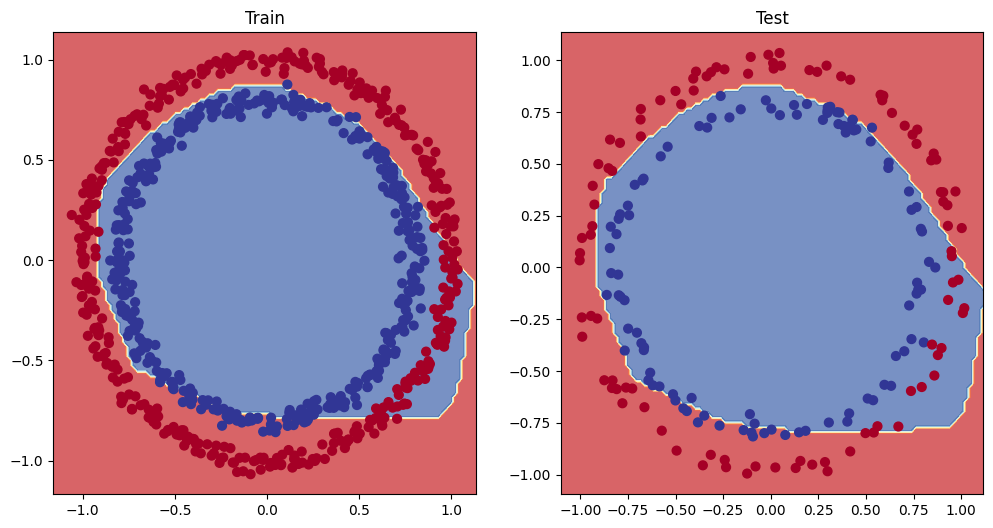

In [ ]:
#PLOT
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_relu, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_relu, X_test, y_test)


# Multi Class Classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


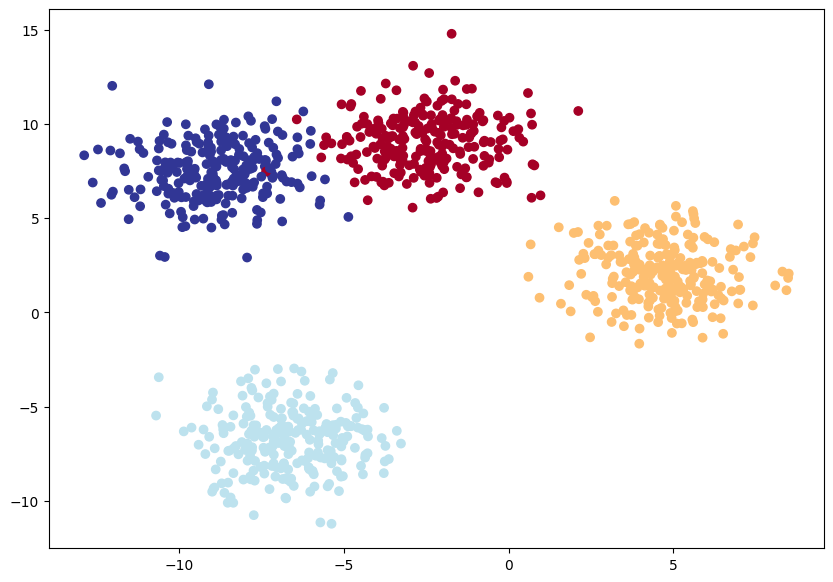

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparams
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1 Create Multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # X features
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, #gives clusters a little shake up
                            random_state=RANDOM_SEED)

#2 Turn Data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # make sure you have long
print(X_blob[:5], y_blob[:5])

#3 Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
#4 Plot
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);


### Building Multi-class Classification


In [ ]:
#create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
#Build multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model

    Args:
      input_featurew (int): # of input features to model
      output_features (int): # of outputs features (# of output calsses)
      hiudden units (int): # of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#create instance of blob model
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device) #8 by default

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
### Create loss function and optimizer for multi class classification model
#loss function=cost function=criterion
#create loss function - measures how wrong model's predictions are
loss_fn = nn.CrossEntropyLoss()

#create optimizer - optimizer updates model params to reduce loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) #lr is hyperparameter

###GEtting prediction probability for a mutli-class Pytorch model
#getting raw outputs, logits
y_logits = model_4(X_blob_test.to(device))
#in order to eval and train and test model, convert logits to
#prediction probs then to pred labels; logits (raw output of model) -> pred probs (use 'torch.softmax') -> pred labels (take argmax of pred prob)

#need activation function to convert logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1) #softmax is used in multi class
# softmax = none are now negative, all sum to 1
# how much chance it is class 0,1,2, or 3
print(y_logits[:5])
print(y_pred_probs[:5])

#convert now to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds




tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [ ]:
# Training and testing loop for multi-class

#fit multi-class model to data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#epochs
epochs = 100

#target device data
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#Loop thru data
for epoch in range(epochs):
    ### Training
    model_4.train()

    #forward pass y logits to pred prob then labels (do i really need softmax or just argmax)
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #loss and acc
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward() #backprob on the loss
    optimizer.step() #update params to better represent patterns in training data

    ### Testing
    model_4.eval() #what does it do?
    with torch.inference_mode():
      test_logits = model_4(X_blob_test)
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    # Print results
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch 0 | Loss: 1.1588, Acc: 40.38% | Test Loss: 1.0755, Test acc: 48.00%
Epoch 10 | Loss: 0.6448, Acc: 96.75% | Test Loss: 0.6607, Test acc: 97.50%
Epoch 20 | Loss: 0.4254, Acc: 98.50% | Test Loss: 0.4307, Test acc: 100.00%
Epoch 30 | Loss: 0.2529, Acc: 99.12% | Test Loss: 0.2451, Test acc: 99.50%
Epoch 40 | Loss: 0.1123, Acc: 99.25% | Test Loss: 0.1023, Test acc: 99.50%
Epoch 50 | Loss: 0.0663, Acc: 99.25% | Test Loss: 0.0585, Test acc: 99.50%
Epoch 60 | Loss: 0.0507, Acc: 99.25% | Test Loss: 0.0429, Test acc: 99.50%
Epoch 70 | Loss: 0.0430, Acc: 99.25% | Test Loss: 0.0349, Test acc: 99.50%
Epoch 80 | Loss: 0.0384, Acc: 99.25% | Test Loss: 0.0299, Test acc: 99.50%
Epoch 90 | Loss: 0.0352, Acc: 99.25% | Test Loss: 0.0266, Test acc: 99.50%


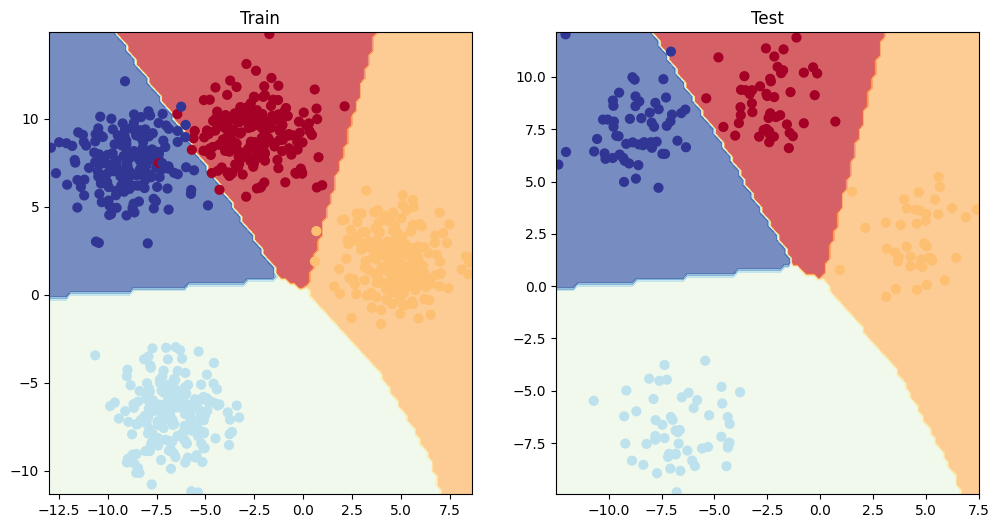

In [ ]:
#Making predictions w pytorch multi-class model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)


y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
#same as y_blob_test now


#Visualize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)



In [ ]:
### More Classification Metrics (to eval classifciation model)
 # Accuracy - out of 100 samples, how many does it get right, good for balanced classes
 # Precision - good for inbalanced, for false positives; inc precision dec recall
 # Recall - good for inbalanced, for false negatives; inc recall dec precision
 # F1-score - combines precision & recall
 # Confusion Matrix -
 # Classification Report -

 # See torchmetrics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
 #on CPU before device

# Calc acc
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [ ]:
#THERE ARE EXERCISES IN THIS MODULE IN EXERCIES SECTION FOR PRACTICE IF NEEDED (7 of them)
#PLUS EXTRA CURRIC ON LEARNPYTORCH.IO
#GO TO PYTORCH LEARNING REPO, WITH SOLNS



# Computer Vision & Convolutional Neural Networks with Pytorch

In [ ]:
# stack overflow for help

In [ ]:
# NHWC more efficient than NCHW
# N: # batches
# H,W: height width
# color channels

# Convoluntional Neural Networks CNN
# PyTorch Computer Vision


## Computer vision libraries in PyTorch
#'torchvision' - base domain library for PyTorch Computer Vision
# 'torchvision.datasets - get datasets and data loading functions for CV
# 'torchvision.models' - get pretrained CV models to leverage with your own probs
# 'torchvision.transforms' - functions for manipulating vison data (images) to be used in ML model
# 'torch.utils.data.Dataset' - Base dataaset class for PyTorch
# 'torch.utils.data.DataLoader' - creates python iterable over a dataset

#import Pytorch
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
# READ pytorch.org/vision/stable/index.html#torchvision
# PACKAGED REFERENCE


#import matplotlib for visualization
import matplotlib.pyplot as plt

# check version
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
### Getting Dataset
# MNIST database: #'s handwritten data
# FAHSION-MNIST: grayscale images of clothing
# all built in, download data, turn into dataloader
# Imagenet is a good tool for downloading example data sets

# Setup Training Data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True, # do we want training dataset?
    download=True, # do we want to download
    transform=torchvision.transforms.ToTensor(), # how we want to transform the data?
    target_transform=None # do we want to transform that target/label? if so how?
)

test_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=False, # do we want testing dataset?
    download=True, # do we want to download
    transform=ToTensor(), # same as above training
    target_transform=None # do we want to transform that target/label? if so how?
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 215kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# See first training example, converts img to tensors CHW in range 0 - 1 not 0 - 255
image, label = train_data[0]
image, label
# types of labels
class_names = train_data.classes
# types of labels into ids
class_to_idx = train_data.class_to_idx
#class_to_idx
# Check Shape
print(f"Image Shape: {image.shape} -> [color_channels, height, width]")
print(f"Image Label: {class_names[label]}")
# RGB is 3 color channels, grayscale is 1


Image Shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image Label: Ankle boot


Image Shape: torch.Size([1, 28, 28])


torch.Size([28, 28])

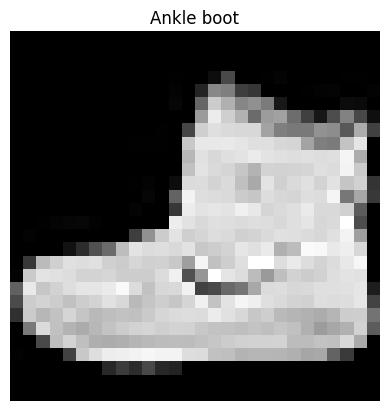

In [ ]:
### Visualizing data
# Matplotlib expects color channels to be last
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze()) # squeeze converts 1,28,28 to 28,28
plt.title(label);

plt.imshow(image.squeeze(), cmap="gray") # cmap shows color
plt.title(class_names[label]);
plt.axis(False);

image.squeeze().shape # for above reference, takes first dimension out

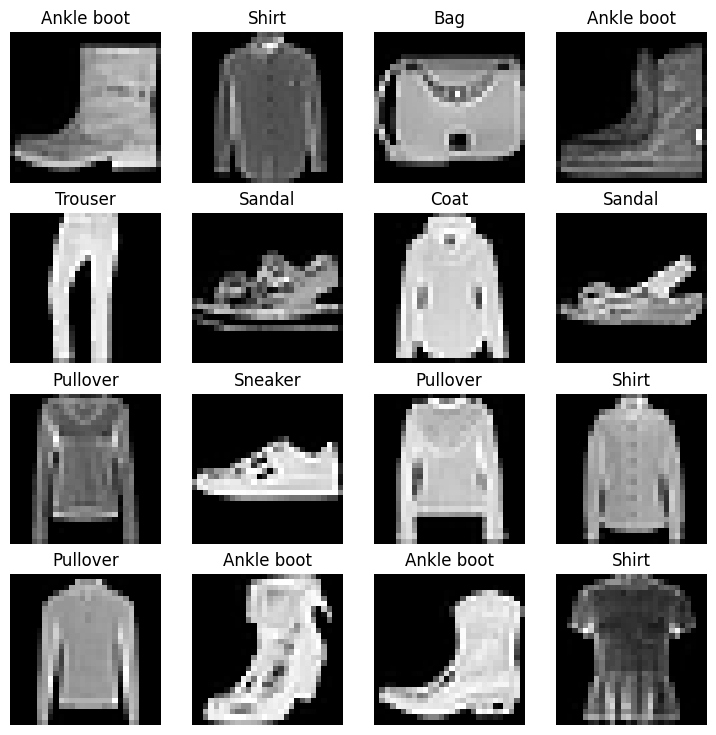

In [ ]:
# Plot more images
# this will give us 16 random images from 0 to train_data which is about 65000
#torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [ ]:
# Linear or non-linear lines for modeling? Probably need non-linear
train_data, test_data
# DataLoader turns dataset into Python iterable (for images, text, audio, etc)
# We want to turn our data into batches or mini-batches
# This will be more computationally efficient, instead of doing 6000 images we do 32 at a time
# It gives our neural network more chances to update its gradients per epoch.
# look up andrew ng minibatch gradient descent

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a2d2b045bd0>, <torch.utils.data.dataloader.DataLoader object at 0x7a2d2b033c40>)
Length of train_dataloader: 1875 batches of 32...
Length of twst_dataloader: 313 batches of 32...
Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


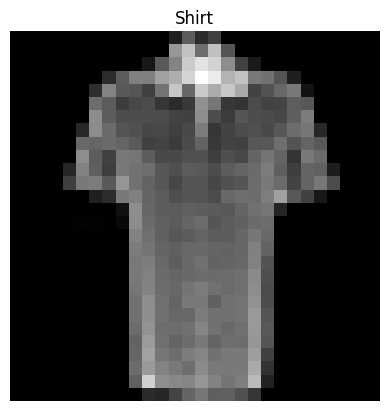

In [ ]:
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32

# turn datasets into iterables (batches)
# torch.utils.data for reference
# DataLoader: num_workers is cores of cpu used
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # so model doesnt learn order in training

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # dont need to shuffle in testing

# Checking what was created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of twst_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")


# Check what's inside training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader)) # features=images, labels=targets
# next() calls the first batch, if you did next again it would be second batch
# iter turns the DataLoader into an iterable; you can do this method or for loop
train_features_batch.shape, train_labels_batch.shape

# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
# Model 0: build baseline model
# Best practice to start with a baseline model when building series of ML experiements
# Baseline Model: model improved upon with subsequent models/experiments
# Start simple, add complexity when necessary

# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
#x.shape 1,28,28 tensor

#Flatten sample
output = flatten_model(x) # perform forward pass on flattened layer
#print what happened
print(f"Shape before flattening: {x.shape}") # 1,28,28 color channels, h, w
print(f"Shape after: {output.shape}") # 1, 784 (28x28) color channels, hxw
# makes single vector as output

#nn.Flatten() layer transforms multi-dimensional input data into a 2D tensor by "flattening" all dimensions except the batch size.


Shape before flattening: torch.Size([1, 28, 28])
Shape after: torch.Size([1, 784])


In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
              input_shape:int,
              hidden_units:int,
              output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # no learnable parameters
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)



torch.manual_seed(42)
# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape =784, # 28*28 h*w
    hidden_units = 10, # how many hidden units in hidden layer
    output_shape = len(class_names) #one for every class, sorta like multi-class
)


dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x) # 10 logits as output

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
# features: parts of images for model to learn (weights and biases)

# Setup Loss Optimizer and Eval Metrics
# Loss Function: nn.CrossEntropyLoss() bc multi-class data
# Optimizer - stick with SGD
# Lets use accuracy as the eval metric bc doing classification problem

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") # in Github click the Raw button and copy that url
  with open("helper_functions.py", "wb") as f: # create helper_functions, give it write binary permissions as f
    f.write(request.content) # get info from github and write into file f
# put helper functions into .py scripts

# Import accuracy metric (could have use torch.metrics if wanted to instead of above)
from helper_functions import accuracy_fn

# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1) # parameters are weights and biases


helper_functions.py already exists, skipping download...


In [ ]:
# Creating Function to time experiments
# ML is very experimental
# Two things to track:
# 1.Model's Performance (loss and accuracy values etc)
# 2.How fast it runs

from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Template for determining time to do a model
start_time = timer()
# some code for a model or training or testing, etc...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


6.043199999794524e-05

In [ ]:
# Creating a training loop and training a model on batches of data...
# Optimizer updates params once per batch not once per epoch

# 1. Loop thru epochs
# 2. Loop thru training batches, perform training steps, calculate training loss per batch
# 3. Loop through testing batches, perform testing steps, calculate test loss per batch
# 4. Visualize
# 5. Time it all

# Import tqdm for progress bar
from tqdm.auto import tqdm #recognize what computer enviro we are using and give us the best progress bar

# Set seed and start timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set number Epochs (keep small for faster training time for experimenting)
epochs = 3

# Create Training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  ### Training
  train_loss = 0 # Instantiate loss
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader): # (image, label/target) ; to keep track of batches we been through
    model_0.train()
    # 1. Forward Pass
    y_pred = model_0(X)

    # 2. Calculate Loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optim 0 grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step (per batch; more room to learn in batch loop not epoch loop)
    optimizer.step()

    # Print result
    if batch % 400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")

  # Adjust training loss to get average training loss per batch per epoch
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader: # batch loop, same as enumerate train_dataloader but without keeping track of which batch # it is at
      # 1. Forward Pass
      test_pred = model_0(X_test)

      # 2. Calc. loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calc. accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # logits -> pred labels

    # Calculate test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate test acc average per batch
    test_acc /= len(test_dataloader)

  # Print results
  print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate Training Time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device)) # checking where model parameters live???


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.5904 | Test Loss: 0.5095, Test acc: 82.0387
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4763 | Test Loss: 0.4799, Test acc: 83.1969
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4550 | Test Loss: 0.4766, Test acc: 83.4265
Train time on cpu: 34.054 seconds


In [ ]:
## Make predictions and get Model 0 results  function created below for eval purposes
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  # The above just denotes that the model is a torch model, etc, not exactly what model it is
    ### Returns dictionary containing results of model predicting on data_loader
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader): # batch loop; most of the process occurs here so use tqdm here
      # Make predictions = forward pass
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(), #turn into single value with .item
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
# Setup Device Agnostic-Code (for using GPU if theres one)
torch.cuda.is_available()
!nvidia-smi

Wed Nov 20 02:07:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              26W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Setup Device Agnostic-Code for GPU
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model 1: Building a better model with non-linearity
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into single vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()

      )

    def forward(self, x: torch.Tensor):
      return self.layer_stack(x)

# Create instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, #this is the output of the flatten layer after 28x28 image goes in
                              hidden_units=10,
                              output_shape=len(class_names)).to(device) #send all variables to GPU if available

next(model_1.parameters()).device # index=0 means first GPU
next(model_0.parameters()).device # CPU; this is the first model for Computer Vision

device(type='cpu')

In [ ]:
# Create Optimizer and Loss Function for Model 1
# Setup Loss function and optimizer
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong model is
optimizer = torch.optim.SGD(params=model_1.parameters(), #updates model params to reduce loss
                            lr=0.1) # parameters are weights and biases

# Functionizing Training and Evaluation/Testing Loops
# Lets create a function for:
#           Training Loop: train_fn()
#           Testing Loop: test_fn()


def train_fn(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             accuracy_fn,
             device: torch.device = device):
  ### Performs training step with model trying to learn on data_loader
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader): # (image, label/target) ; to keep track of batches we been through
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass (outputs the raw outputs/logits from model)
    y_pred = model(X)

    # 2. Calculate Loss and Accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # logits to pred labels

    # 3. Optim 0 grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step (per batch; more room to learn in batch loop not epoch loop)
    optimizer.step()

  # Adjust training loss & acc to get average training loss per batch per epoch
  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")



def test_fn(model: torch.nn.Module,
            data_loader: torch.utils.data.dataloader,
            loss_fn: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device):
### Performs Testing Loop step on model going over data_loader
  test_loss, test_acc = 0, 0

  model.eval() # put model in eval mode

  with torch.inference_mode(): # turn on inference (prediction) mode context manager
    for X, y in data_loader: # batch loop, same as enumerate train_dataloader but without keeping track of which batch # it is at
      # Send data to target device to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass (outputs logits)
      test_pred = model(X)

      # 2. Calc. loss (accumulatively)
      test_loss += loss_fn(test_pred, y)

      # 3. Calc. accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # logits -> pred labels

    # DO the below within inference mode

    # Calculate test loss average per batch
    test_loss /= len(data_loader)
    # Calculate test acc average per batch
    test_acc /= len(data_loader)

  # Print results
  print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

In [ ]:
# Train & Test Model 1

torch.manual_seed(42)
# Measure Time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set Epochs
epochs = 3

# Create a optimization and eval loop using train & test_fn
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n----------")
  train_fn(model=model_1,
           data_loader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           accuracy_fn=accuracy_fn,
           device=device)

  test_fn(model=model_1,
          data_loader=test_dataloader,
          loss_fn=loss_fn,
          accuracy_fn=accuracy_fn,
          device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Train Loss: 1.09199 | Train Acc: 61.34%
Test Loss: 0.95636, Test acc: 65.00%

Epoch: 1 
----------
Train Loss: 0.78101 | Train Acc: 71.93%
Test Loss: 0.72227, Test acc: 73.91%

Epoch: 2 
----------
Train Loss: 0.67027 | Train Acc: 75.94%
Test Loss: 0.68500, Test acc: 75.02%

Train time on cuda: 30.309 seconds


In [ ]:
# Sometimes, CPU may be faster than GPU depending on data/hardware:
# 1. Overhead for copying data/model to and from GPU outweighs compute benefits offered by GPU
# 2. Hardware has better CPU in terms of compute capability than GPU (rare)
# Horas He - First Principles go BRRRRR

In [ ]:
# Define Eval Model again
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  # The above just denotes that the model is a torch model, etc, not exactly what model it is
    ### Returns dictionary containing results of model predicting on data_loader
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader): # batch loop; most of the process occurs here so use tqdm here
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions = forward pass
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(), #turn into single value with .item
          "model_acc": acc}

In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)
model_1_results # Gpu same model

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results # Cpu same model

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
# Model 2: Building a Convolutional Neural Network (CNN)
# Also known as ConvNets
# CNN's are known for their capabilities to find patterns in visual data
# CNN Explainer
#     -Kernel: filter
#     -block = multiple layers (convolutional layer, ReLu, Pooling)

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  ### Model architecture that replicated the TinyVGG
  ### model from CNN explainer website
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    # First block
    self.conv_block_1 = nn.Sequential(
        # 2 dimensional, creating a conv layer
        nn.Conv2d(in_channels=input_shape, # number of channels in visual data
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # values above we can set ourselves in our NN's => hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # taking max of an input, which is a 2x2 of a pixel
    )
    # Next block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    # Last layer is usually linear, called classification layer, what we did before on model 0,1
    self.classifier = nn.Sequential(
        nn.Flatten(), # output of these two above blocks is a multi-dimensional tensor
        nn.Linear(in_features=hidden_units*7*7, # trick: flatten hidden units
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output Shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output Shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output Shape of Classifier: {x.shape}")
    return x


In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, #1 for BnW, 3 for color )
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

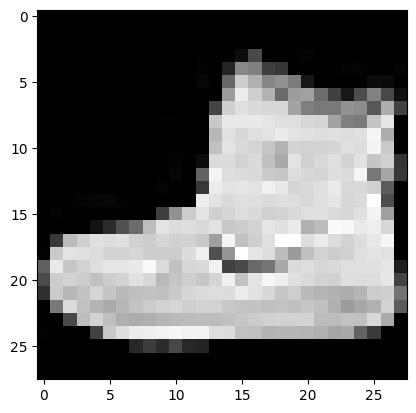

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
# Pass Image through Model
# In video, troubleshooting tips: 18:20 ->
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
### 7.1 Stepping Through nn.Conv2d()
torch.manual_seed(42)

# Create batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image Batch Shape: {images.shape}")
print(f"Single Image Shape: {test_image.shape}")
print(f"Test Image:\n {test_image}")

Image Batch Shape: torch.Size([32, 3, 64, 64])
Single Image Shape: torch.Size([3, 64, 64])
Test Image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
torch.manual_seed(42)
# Create a single Conv2d Layer
conv_layer = nn.Conv2d(in_channels=3, # color channels same as images that we specified a couple lines above
                       out_channels=10, # hidden units
                       kernel_size=3, # 3 == 3x3 (tuple); 3x3 size to be calculated into output
                       stride=1, # how many pixels we jump/skip, so smaller output
                       padding=0) # more padding add extra on input, so kernel can operate corners better
# Pass data through convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0)) # unsqueeze to make 4D
conv_output.shape # 1,10,62,62
# test_image.unsqueeze(0).shape # 1,3,64,64

torch.Size([1, 10, 62, 62])

In [ ]:
# Stepping Through nn.MaxPool2d()

# Print out original image shape without unsqueezed dimension
print(f"Test Image Original Shape: {test_image.shape}")
print(f"Test Image with Unsqueezed Dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through max pool layer (cuts in half)
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test Image Original Shape: torch.Size([3, 64, 64])
Test Image with Unsqueezed Dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1,1,2,2))
print(f"\nRandom Tensor:\n{random_tensor}")
print(f"Random Tensor Shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
# Pass random tensor through max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax Pool Tensor:\n {max_pool_tensor}")
print(f"Max Pool Tensor Shape: {max_pool_tensor.shape}")




Random Tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random Tensor Shape: torch.Size([1, 1, 2, 2])

Max Pool Tensor:
 tensor([[[[0.3367]]]])
Max Pool Tensor Shape: torch.Size([1, 1, 1, 1])


In [ ]:
### Training CNN: setup loss function and optimizer for model_2
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### Training and testing model_2 using training and test functions
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure Time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and Test Model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n----------")
  train_fn(model=model_2,
           data_loader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           accuracy_fn=accuracy_fn,
           device=device)
  test_fn(model=model_2,
          data_loader=test_dataloader,
          loss_fn=loss_fn,
          accuracy_fn=accuracy_fn,
          device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Train Loss: 0.59628 | Train Acc: 78.30%
Test Loss: 0.38549, Test acc: 86.03%

Epoch: 1 
----------
Train Loss: 0.35840 | Train Acc: 87.08%
Test Loss: 0.36208, Test acc: 86.86%

Epoch: 2 
----------
Train Loss: 0.32132 | Train Acc: 88.34%
Test Loss: 0.32487, Test acc: 88.31%

Train time on cuda: 38.728 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             )
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32486987113952637,
 'model_acc': 88.30870607028754}

In [ ]:
model_0_results # model 2 is more efficient than 0... CNN's work

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
## Compare model results and training time
import pandas as pd
compare_results = pd.DataFrame([model_0_results, # CPU linear
                                model_1_results, # GPU with non-linear
                                model_2_results]) # CNN (tiny VGG with CNN explainer)
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.324870,88.308706


In [ ]:
# Add Training Time to results comparison
compare_results["Training Time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,Training Time
0,FashionMNISTModelV0,0.476639,83.426518,34.053689
1,FashionMNISTModelV1,0.685001,75.019968,30.308571
2,FashionMNISTModelV2,0.324870,88.308706,38.727666


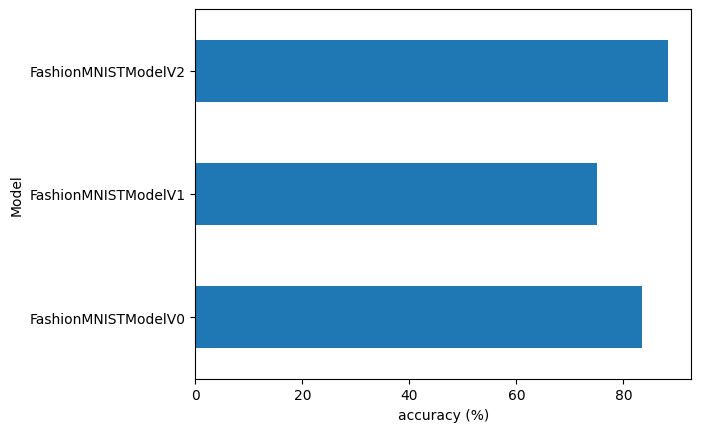

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("Model");

In [ ]:
## Make and Evaluate Random Predictions with best model
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward Pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probabilities (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack pred_probs to turn list into a single tensor
  return torch.stack(pred_probs)

Text(0.5, 1.0, 'Sandal')

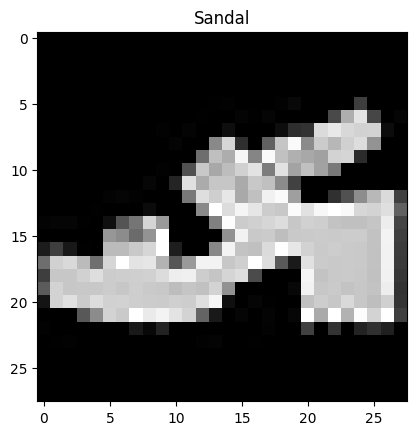

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9): # k= # of samples ; test_data = data set not converted to data loader
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape
plt.imshow(test_samples[0].squeeze(),cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make Predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two pred probs
pred_probs[:2]

# need to convert into labels via argmax
pred_classes = pred_probs.argmax(dim=1)
class_names[pred_classes[1]]

'Trouser'

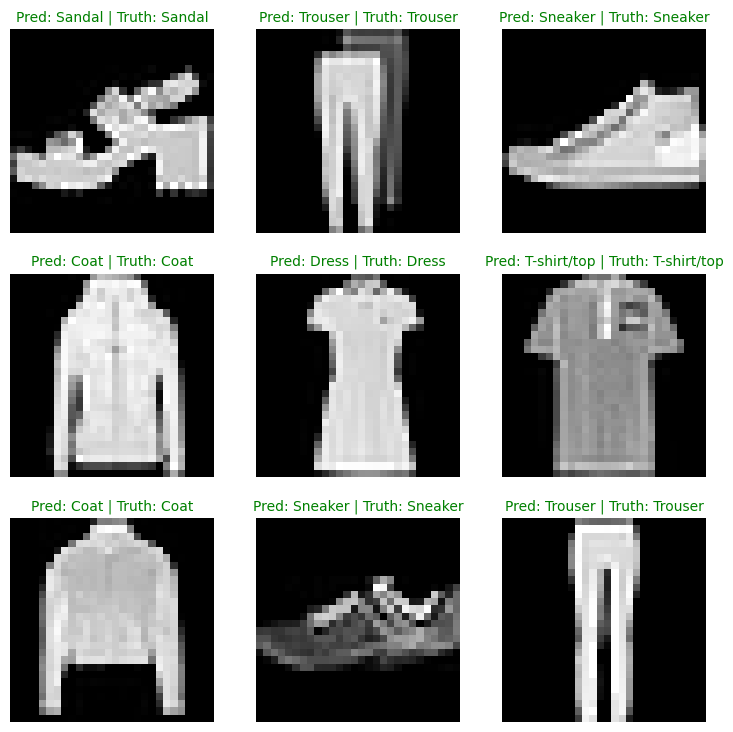

In [ ]:
# Plot Predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot for each sample
  plt.subplot(nrows, ncols, i+1) # i+1 because cant start at 0

  # Plot target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find Predication (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get Truth Label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") # red text if prediction is false

  plt.axis(False);

In [ ]:
# Making a confusion matrix for further prediction evaluation
# Good way of visual evaluation of classification models
# 1. Make predictions with our trained model on the test dataset
# 2. Make a confusion matrix 'torchmetrics.ConfusionMatrix'
# 3. Plot confusion matrix using 'mlxtend.plotting.plot_confusion_matrix()'

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1 Make prediction with trained model
y_preds =  []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do forward pass
    y_logit = model_2(X)
    # Turn into pred probs then pred labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1) # could do just argmax
    # Put prediction on CPU for eval
    y_preds.append(y_pred.cpu())

# Concatenate list of preds into tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version 0.19.0 or newer required"
except:
     !pip install -q torchmetrics -U mlxtend #-q = download, -U = upgrade
     import torchmetrics, mlxtend
     print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.2


In [ ]:
#Showing Variables from below
class_names
y_pred_tensor[:10]
test_data.targets # labels = targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup Confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

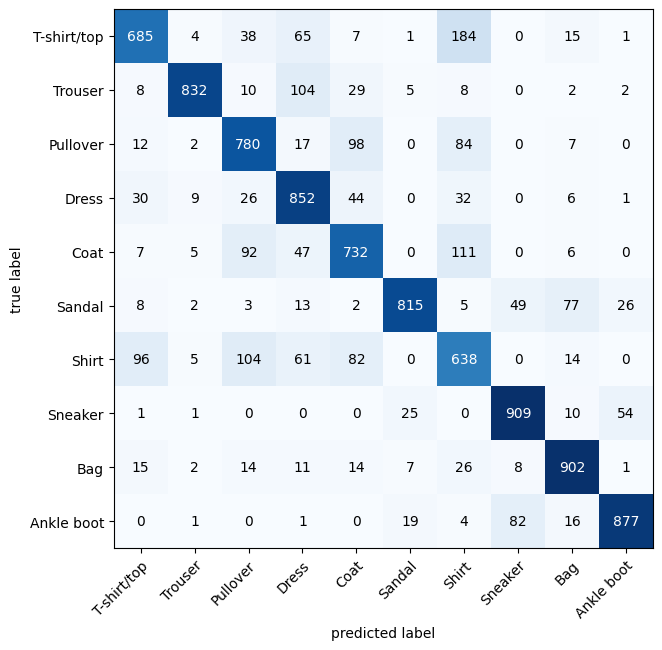

In [ ]:
# 3. Plot confusion matrix
fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), #matplotlib likes working with numpy
                                class_names=class_names,
                                figsize=(10,7)
)

In [ ]:
## 11. Save and load best performing model
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance of model 2
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1, # color channels
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to target device
loaded_model_2.to(device)

<ipython-input-75-a1abff0f8113>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results # model 2 before loading in the saved stat dict

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32486987113952637,
 'model_acc': 88.30870607028754}

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)

loaded_model_2_results # same numbers as model 2 results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32486987113952637,
 'model_acc': 88.30870607028754}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02) # tolerance of difference

tensor(True)

In [ ]:
###### MIT's Intro to Deep Computer Vision

# PyTorch Custom Datasets


In [ ]:
# Need to go through pre-processing steps to import custom data
# TorchVision for pictures
# TorchText for texts
# TorchAudio for audio
# TorchRec for recommending similar products

In [ ]:
############# FoodVision Mini (Classify Food)
# 04 PyTorch Custom Datasets Video Notebook
# How do get your own data into PyTorch
# One way: custom datasets

## Domain Libraries
# Depending on vision, text, audio, etc, look into each of PyTorch domain libraries for existing data loading functions and customizable data loading functions


## 0. Importing PyTorch and setting up device-agnostic code
import torch
from torch import nn

#Note: need PyTorch 1.10.0 +
torch.__version__

'2.5.1+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
!nvidia-smi

Sat Jan  4 03:46:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
## 1. Get Data
# Dataset is a subset of the Food101 dataset
# Food101 starts with 101 different classes of food, but we'll do 3 classes and
# only 10% of the 1000 images per class (750 training, 250 testing) so: 75 training, 25 testing
# it is important to start small then increase scale when needed
# speed up how fast you can experiment

In [ ]:
import requests
import zipfile
from pathlib import Path
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesnt exist, download and prepare by unzipping
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True) # exist_ok (optional) : A default value False is used for this parameter. If the target directory already exists an OSError is raised if its value is False otherwise not. For value True leaves directory unaltered.

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

# Remove zip file

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
## 2. Becoming one with the data (data preparation and data exploration)
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

steak
Random image path: data/pizza_steak_sushi/train/steak/3074367.jpg
Image class: steak
Image height: 339
Image width: 512


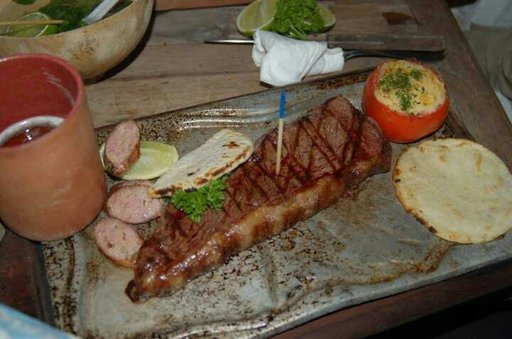

In [ ]:
### 2.1 Visualizing an Image
# Write code to:
# 1. Get all image paths
# 2. Pick a random image path using Python's random.choice()
# 3. Get image class name (which directory it is in) 'pathlib.Path.parent.stem' stem=pizza
# 4. Since we are working with images, open with Python's PIL (pillow)
# 5. Show image and print metadata

import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #glob together all images that suit a certain pattern
                                      # * = test,or train, next *=inside test,train; last * = any of the files in pizza,etc
# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

random_image_path

# 3. Get image class from path name (name of directory where the img is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print Meta data
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") # From PIL library
print(f"Image width: {img.width}")
img


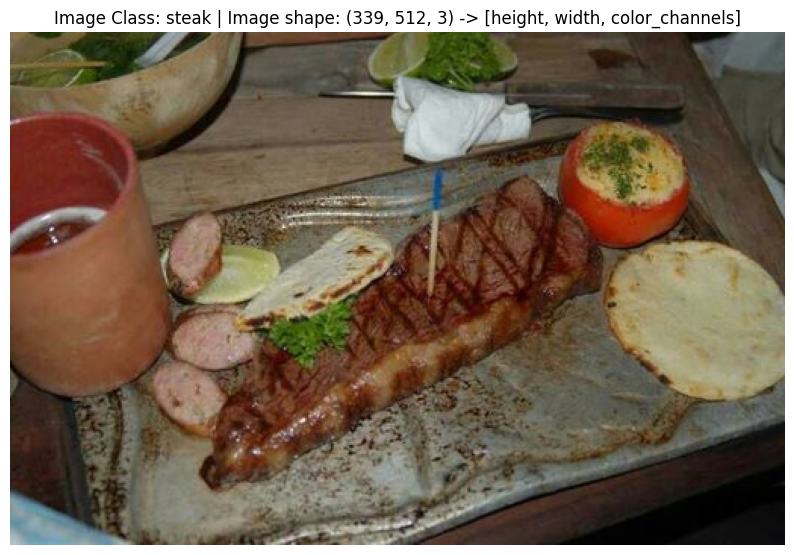

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

# Plot image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
# 3. Transforming Data
# Before we can us image data:
# 1. Turn target data into tensors (numerical representation of img)
# 2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader
# we'll call these Dataset and DataLoader

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms
# Transforms help get your imgs ready to be used with a model/perform data augmentation
# Write a Transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch.Tensor
    transforms.ToTensor()
])

# This converts pil images to tensors

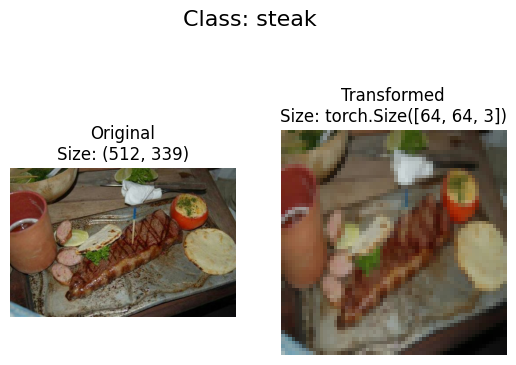

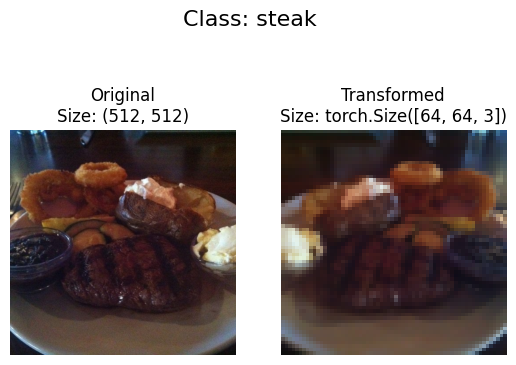

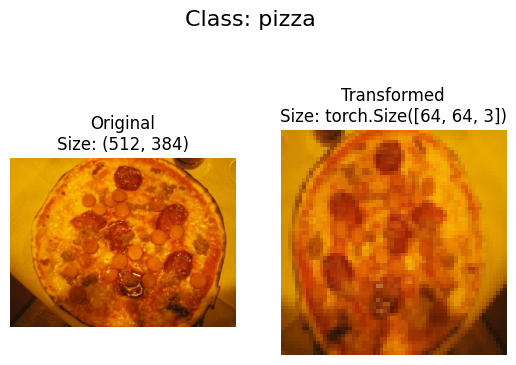

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None): # n is number of images to transform at a time
  """Selects random images from path of images and loads/transforms them then plots the original vs the transformed version """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target img
      transformed_image = transform(f).permute(1, 2, 0) # C, H, W -> H, W, C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False) # or "off"

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)




In [ ]:
### 4. Option 1: Loading image data using ImageFolder

# We can load image classification data using 'torchvision.datasets.ImageFolder'

# Use ImageFolder to create dataset(s) -> dont need a target transform, because our data is in standard image classification format, if it isnt need different dataloader
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform the data
                                  target_transform=None) # transform for target/label ; None is default

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class data
class_names = train_data.classes
class_names

# Get Class names as a dict
class_dict = train_data.class_to_idx
class_dict # shows integer of dict for each class

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

# Many things to look at below
#train_data.

# Index on the train_data dataset to get a single img and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image Permuted: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

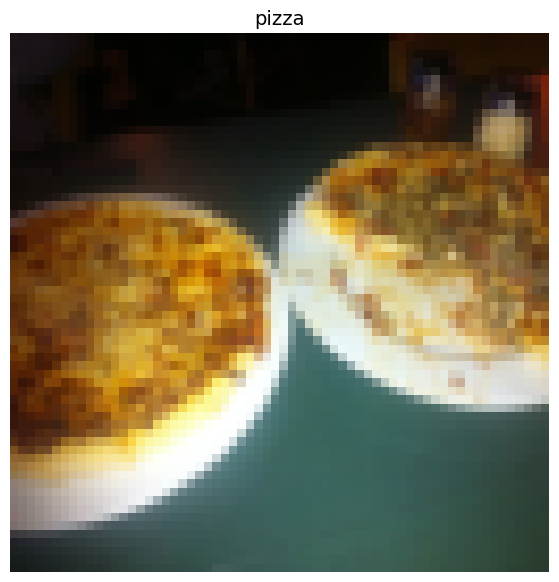

In [ ]:
# Rearrange the order of dimensions to plot
img_permute = img.permute(1, 2, 0) # these numbers are the original points

# Print out different shapes
print(f"Original Shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permuted: {img_permute.shape} -> [height, width, color_channels]")

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("Off")
plt.title(class_names[label], fontsize=14)

In [ ]:
import os
os.cpu_count() # checking how many cpus

2

In [ ]:
### 4.1 Turn Loaded imgs into Dataloaders
# A dataloader is going to help us turn our datasets into interables and we can customise the batch_size so our model can see batch_size imgs at a time
# Turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True) # mixing data up
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # dont shuffle test data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7934860d47c0>,
 <torch.utils.data.dataloader.DataLoader at 0x793485e03070>)

In [ ]:
len(train_dataloader), len(test_dataloader) # both should total to 300

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader)) # batch size is 1, can change if want

print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


In [ ]:
# Pretending we didnt have ImageFolder to import dataset so that we can use DataLoader
# Option 2 : Loading Img Data with Custom "Dataset"
# 1. Load images from file
# 2. Get class names from Dataset
# 3. Get classes as dictionary from Dataset

# Pros:
# Can create a Dataset out of almost anything, not limited to PyTorch pre-built Dataset functions

# Cons:
# It doesn't mean it will work, using a custom Dataset requires more code, prone to errors or performance

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset # All custom datasets in PyTorch often subclass this
from torchvision import transforms
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder(), ie how we want our custom function to have
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
### 5.1 Creating a helper function to get class names
# Need function to get class names using os.scandir() to traverse target directory
# (ideally the directory to be in standard img classification format)
# Raise an error if class names arent found
# Turn class names into dict and list and return them

# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

Target dir: data/pizza_steak_sushi/train


In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get class names by scanning target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise error if class names could not be found
  if not classes:
      raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels (computers prefer numbers to strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)} # class_name from train_data.classes
  return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
### 5.2 Create custom Dataset to replicate ImageFolder

# To create our own custom dataset, we need to:
# 1. Subclass 'torch.utils.data.Dataset'
# 2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we want to transform data
# 3. Create several attributes:
# - Paths - paths of imgs
# - Transform - transform we'd like to use
# - Classes - a list of the target classes/labels
# - class_to_idx - a dict of target classes mapped to integer labels
# 4. Create function to 'load_images()', this function will open an img
# 5. Overwrite '__len()__' method to return length of our dataset
# 6. Overwrite '__getitem()__ method to return a given sample when passed an index


# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset): # getting Dataset's functionality
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None): # transform optional
    # 3. Create class attriubtes
    # Get all img paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # from a train or test folder, get image paths within them
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)  # premade function we made earlier

  # 4. Create function to load imgs
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
   "Returns total number of samples"
   return len(self.paths)

  # 6. Overwrite __getitem()__ method to return our particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: # replicates img, label
    "Returns one sample of data, data and label (X,y) at the given index"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data (X,y) img, label
    else:
      return img, class_idx # return untransformed img and label


In [ ]:
# Create a transform
from torchvision.transforms import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                     transforms.Resize(size=(64,64)),
                                     transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7934860d5a50>,
 <__main__.ImageFolderCustom at 0x7934860d7190>)

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(train_data_custom.class_to_idx==train_data.class_to_idx)

True
True


In [ ]:
############################################## some of the images are rotated... why

### 5.3 Create a function to display random images
# 1. Take in a Dataset and a number of other parameters such as class names and how many imgs to visualize
# 2. To prevent display getting out of hand, lets cap # of imgs to see at 10
# 3. Set random seed for reproducability
# 4. Get list of random sample indexes from target dataset
# 5. Setup a Matplotlib plot
# 6. Loop through random sample indexes and plot w matplotlib
# 7. Make sure dimensions of imgs match up with matplotlib (HWC)


# 1. Create function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For Display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup PLot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color,H,W] -> [H,W,color]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

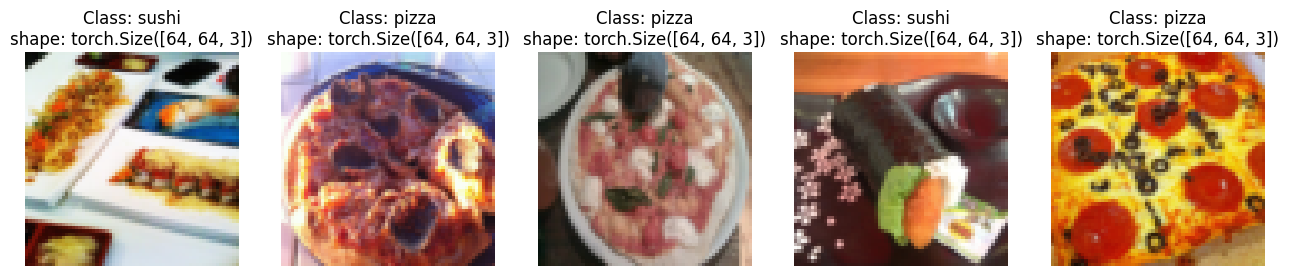

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

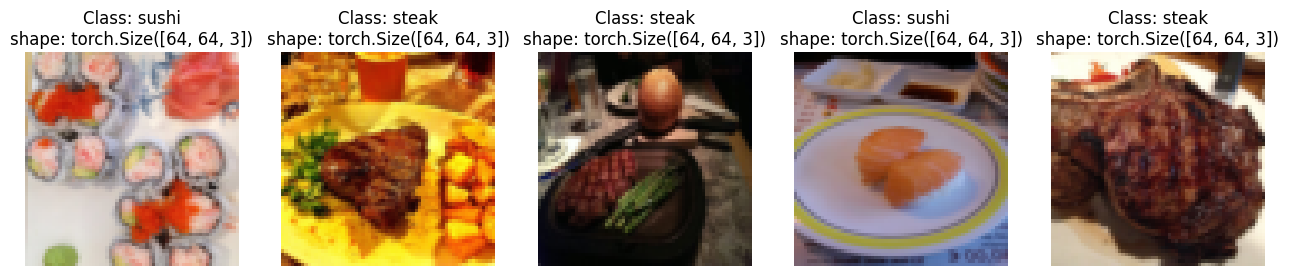

In [ ]:
# Display random imgs from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

In [ ]:
### 5.4 Turn Custom Loaded Images into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7934860d74c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7934860d6aa0>)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

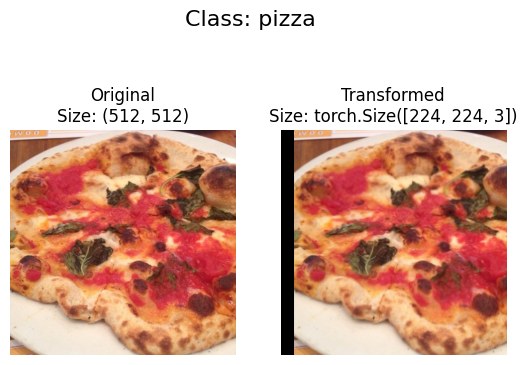

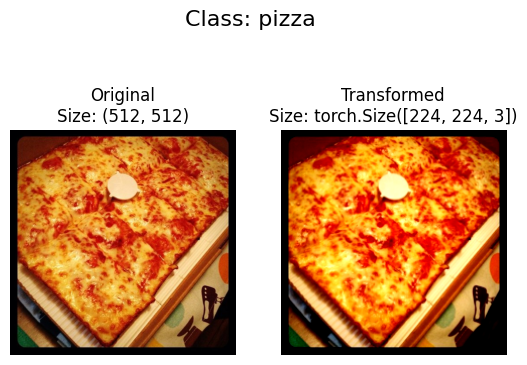

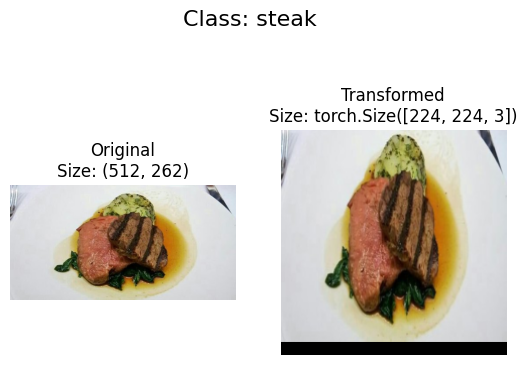

In [ ]:
## 6. Other forms of transforms (data augmentation)
# Data Augmentation is process of artificially adding diversity to training data
# In case of image data, this may mean applying varying image transformations
# to the training images.

# One type of data augmentation used to train PyTorch vision models to state of the art lvls
# Might help model learn better, more generalizable to unseen data

# pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision ......

# We will look at trivialaugment - randomly changes things in images, artificially adding diversity
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31), # lower number less impactful to img change
                                      transforms.ToTensor(),
])

test_transform = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()
])

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

# Plot random transformed imgs
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

In [ ]:
## 7. Model 0: TinyVGG without data augmentation
# Replicate TinyVGG architecture from CNN explainer website
### 7.1 Create Transforms and loading data for Model 0
# Create simple transform
simple_transform = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()
])

# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7934854d1cc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7934854d27d0>)

In [ ]:
### 7.2 Create TinyVGG model class
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, #use error code on forward pass to give you hint what to multiply (in this case: 10*13*13)
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # same as above
    # second return benefits from operator fusion (speeds up GPU computations)
    # how to make your GPUs go brrr


torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
### 7.3 Try a forward pass on a single img (to test model)
# get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

# try forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [ ]:
### 7.4 Use 'torchinfo' to get an idea of the shapes going through our model

# Install torchinfo, import if available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # batch of 1 img, 3 color channels, 64x64
# does a forward pass to get summary

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [ ]:
### 7.5 Create train and test loop functions that are generic (we did this earlier sorta)

# 'train_step()' - takes in a model and dataloader and trains the model on the dataloader
# 'test_step()' - takes in a model and dataloader and tests the model on the dataloader

# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dataloader data batches
  for batch, (X,y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_pred = model(X) #output=model logits

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric and accumulate
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) #label
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get avg loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)

      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1) # softmax is not 100% necessary
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch\
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [ ]:
### 7.6 Creating a 'train()' function to combine 'train_step()' and 'test_step()'
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print what's happening
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # 5. Update results dictionary every epoch
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results